**Proposta nova:**
- Uso de LLM para reescrita de politeness e avaliação da reescrita utilizando LLM e algoritmos de aprendizado de máquina.

In [1]:
# %pip install pandas
# %pip install matplotlib
# %pip install --upgrade numpy
# %pip install seaborn
# %pip install scikit-learn
# %pip install ipywidgets
# %pip install tensorflow
# %pip install --upgrade gensim
# %pip install python-dotenv
# %pip install openai

## runtime compatibility problems (have to run even after install requirements.txt):
# %pip install tf-keras 
# %pip install evaluate
# %pip install accelerate

---

### Activate venv:

In [2]:
## Activate python venv:

# !python -m venv .venv
# Then, select the Jupyter kernel to use the venv, then execute the call below

In [3]:
## Install requirements in the .venv
# %pip install -r requirements.txt

In [4]:
## In case of updating requirements
# %pip freeze > requirements.txt

---
## > Imports

In [2]:
import pandas as pd
import os
from dotenv import load_dotenv
from openai import OpenAI
from IPython.display import clear_output
from pprint import pprint
from string import punctuation
import seaborn as sns
import matplotlib.pyplot as plt
import re
from transformers import AutoTokenizer, DataCollatorWithPadding, TrainingArguments, AutoModelForSequenceClassification, Trainer, TextClassificationPipeline
import numpy as np
import evaluate
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset 
import torch 
from datetime import date
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import json

load_dotenv()

OPENAI_PROJECT = os.getenv("OPENAI_PROJECT_ID")
OPENAI_APIKEY = os.getenv("OPENAI_APIKEY")

## ~40 sec load

---
### Dataframe:

In [6]:
path = 'PolitenessDataset-FULL.csv'

# Original Dataframe
OriginalPolitenessDF = pd.read_csv(path)
# print('Data Stats:', OriginalPolitenessDF.describe())

# Experiments Dataframe
TargetDf = OriginalPolitenessDF.copy()

TargetDf.head(4)

,Venue,Review ID,review,Tone,Review URL
0,ShitMyReviewerSay,NaN,"It is early in the year, but difficult to imag...",2,NaN
1,ShitMyReviewerSay,NaN,You do not use the empirical data for the anal...,2,NaN
2,ShitMyReviewerSay,NaN,I understand that Wikipedia is not the best so...,3,NaN
3,ShitMyReviewerSay,NaN,Reviewer #1: 'The project can hardly be descri...,3,NaN


In [7]:
# Basic Transformations:

# Codificação
TargetDf['CodeVenue'] = TargetDf['Venue'].astype('category').cat.codes
# ReviewId
TargetDf['Index'] = TargetDf.index
# Reorder
TargetDf = TargetDf[['Index', 'CodeVenue', 'review', 'Tone']]
TargetDf.rename(columns={'review': 'RawReview'}, inplace=True)
TargetDf.head()

,Index,CodeVenue,RawReview,Tone
0,0,3,"It is early in the year, but difficult to imag...",2
1,1,3,You do not use the empirical data for the anal...,2
2,2,3,I understand that Wikipedia is not the best so...,3
3,3,3,Reviewer #1: 'The project can hardly be descri...,3
4,4,3,The figures are dishonest and not all that use...,2


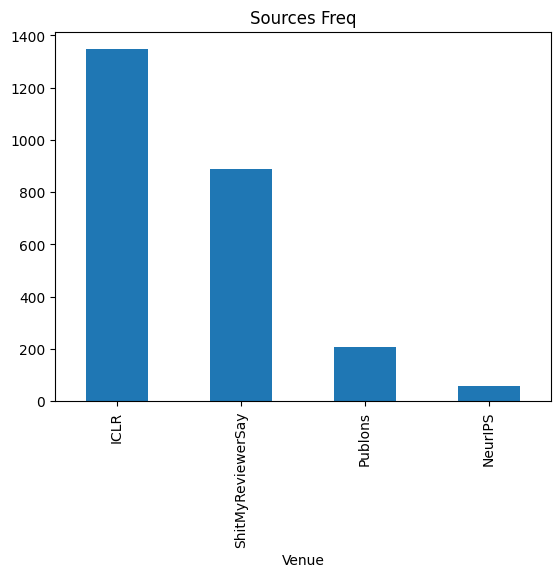

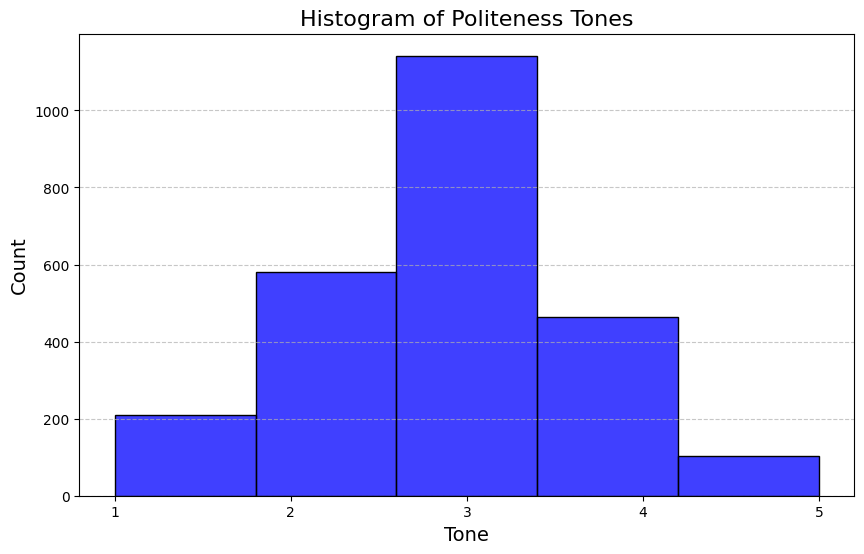

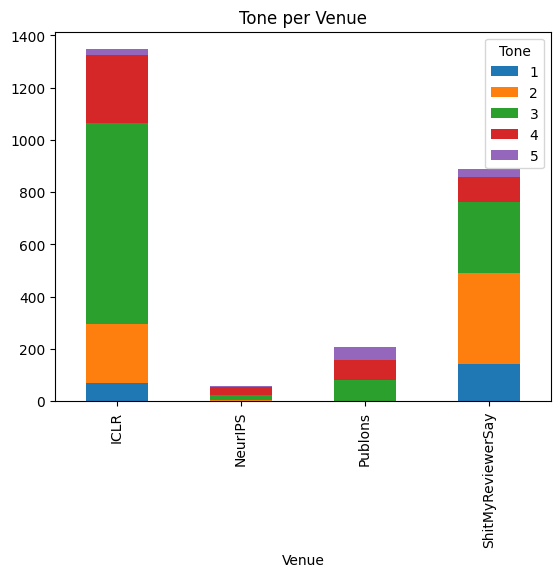

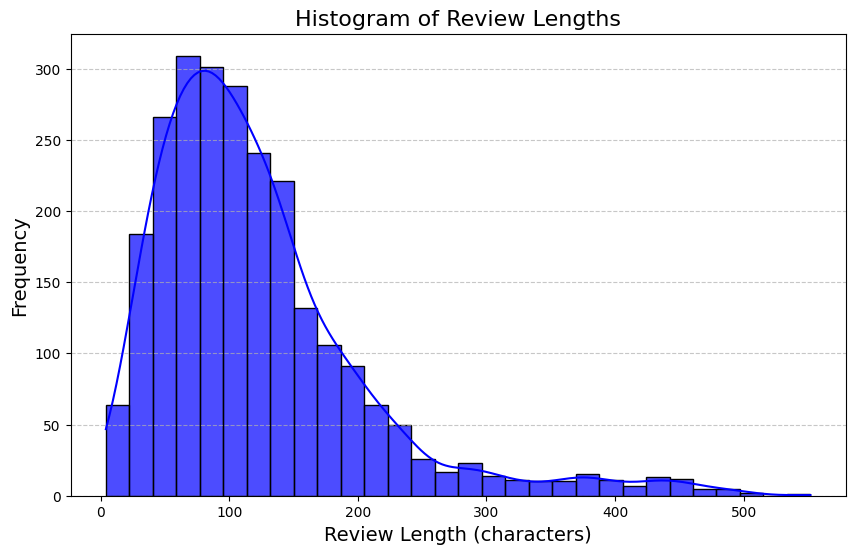

In [8]:
# Some visuals

# Plotting the distribution of the sources
OriginalPolitenessDF['Venue'].value_counts().plot(title='Sources Freq', kind='bar')
plt.show()

# Tone distribution
plt.figure(figsize=(10, 6))
sns.histplot(OriginalPolitenessDF['Tone'], bins=5, fill=True, color='blue', edgecolor='black')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(ticks=[1, 2, 3, 4, 5])
plt.title("Histogram of Politeness Tones", fontsize=16)
plt.xlabel("Tone", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.show()

# Plot tone per venue, stacked
OriginalPolitenessDF.groupby(['Venue', 'Tone']).size().unstack().plot(kind='bar', stacked=True, title='Tone per Venue')
plt.show()

# Lenghts
lengths = TargetDf['RawReview'].str.len()

# Plot histogram of review lengths
plt.figure(figsize=(10, 6))
sns.histplot(lengths, bins=30, kde=True, color='blue', alpha=0.7)  # Seaborn for enhanced visuals
plt.title("Histogram of Review Lengths", fontsize=16)
plt.xlabel("Review Length (characters)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

---
### Pre Processamento:

In [9]:
def ReviewPreProcess(x: str):
    '''
    Esta função realiza:
    - Conversão para string
    - Remoção de Pontuação
    - Tudo minusculo
    - Remoção de links
    - Remoção de menções
    - Remoção de palavras com números
    - Normalização de espaços
    '''
    
    # Converter para string, caso não seja
    if not isinstance(x, str):
        return ''  # Retorna string vazia para entradas inválidas
    
    new_x = x
    for c in punctuation:
        new_x = new_x.replace(c,'')
    pattern = r"""
    http\S+|         # Remove links
    @\w+|            # Remove mentions
    \b\w*\d\w*\b|    # Remove words containing numbers
    \s+              # Normalize spaces
    """    
    new_x = re.sub(pattern, ' ', new_x, flags=re.VERBOSE) #removendo pontuação do texto
    return new_x.lower().strip()

# TargetDf.rename(columns={'review': 'raw_review'}, inplace=True)
TargetDf['TransformedReview'] = TargetDf['RawReview'].apply(ReviewPreProcess)
TargetDf

,Index,CodeVenue,RawReview,Tone,TransformedReview
0,0,3,"It is early in the year, but difficult to imag...",2,it is early in the year but difficult to imagi...
1,1,3,You do not use the empirical data for the anal...,2,you do not use the empirical data for the anal...
2,2,3,I understand that Wikipedia is not the best so...,3,i understand that wikipedia is not the best so...
3,3,3,Reviewer #1: 'The project can hardly be descri...,3,reviewer the project can hardly be described...
4,4,3,The figures are dishonest and not all that use...,2,the figures are dishonest and not all that useful
...,...,...,...,...,...
2495,2495,3,The scientific contribution of this paper - if...,2,the scientific contribution of this paper if t...
2496,2496,3,Reviewer 2: The proposal is also poorly writte...,2,reviewer the proposal is also poorly written...
2497,2497,3,The paper could be considered for acceptance g...,3,the paper could be considered for acceptance g...
2498,2498,3,I don't see how your approach has potential to...,2,i dont see how your approach has potential to ...


Len of short reviews: 59


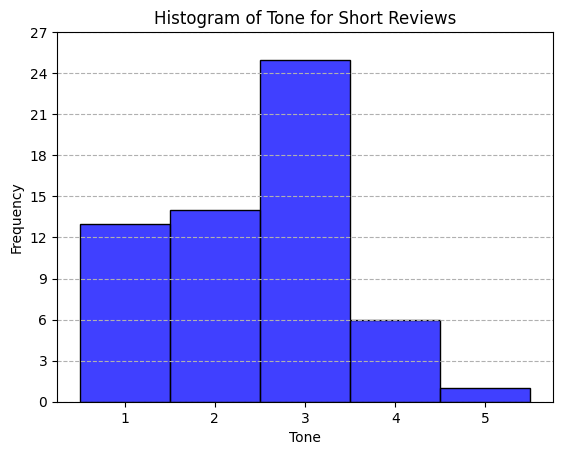

In [10]:
filtered_data = TargetDf[TargetDf['TransformedReview'].str.len() < 20]['Tone']

print('Len of short reviews:', len(filtered_data))

# use sns to create a histogram of the Tone column:
sns.histplot(filtered_data, kde=False, discrete=True, color='blue')

# Adicionar título e rótulos aos eixos
plt.title('Histogram of Tone for Short Reviews')
plt.xlabel('Tone')
plt.ylabel('Frequency')
plt.yticks(range(0, 30, 3))
plt.grid(axis='y', linestyle='--')

# Mostrar o gráfico
plt.show()

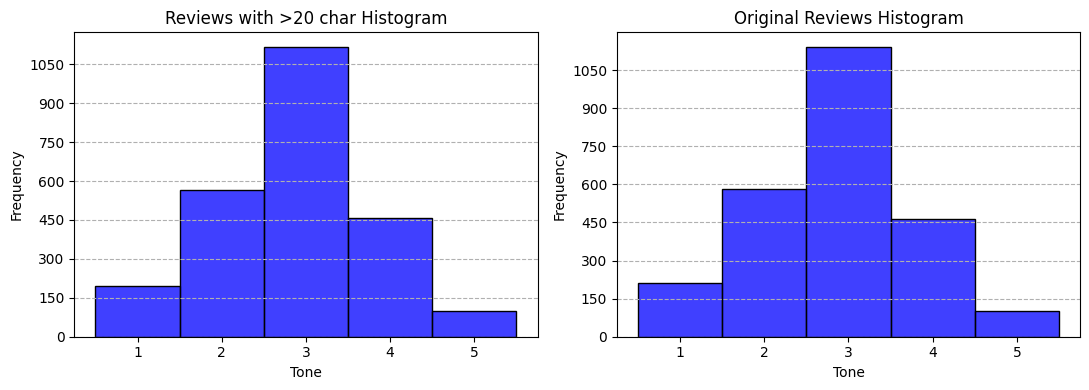

Filtered Dataframe: Tone
3    1117
2     567
4     459
1     197
5     101
Name: count, dtype: int64
Total of Reviews: 2441 

Original Dataframe: Tone
3    1142
2     581
4     465
1     210
5     102
Name: count, dtype: int64
Total of Original Reviews: 2500


In [11]:
# Only keep reviews with more than 20 characters
TargetDf2 = TargetDf[TargetDf['TransformedReview'].str.len() >= 20].copy()

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(11, 4))  # 1 row, 2 columns

# First subplot: Reviews with >20 characters
sns.histplot(TargetDf2['Tone'], kde=False, discrete=True, color='blue', ax=axes[0])
axes[0].set_title('Reviews with >20 char Histogram')
axes[0].set_xlabel('Tone')
axes[0].set_ylabel('Frequency')
axes[0].set_yticks(range(0, 1200, 150))
axes[0].grid(axis='y', linestyle='--')

# Second subplot: Original Reviews
sns.histplot(TargetDf['Tone'], kde=False, discrete=True, color='blue', ax=axes[1])
axes[1].set_title('Original Reviews Histogram')
axes[1].set_xlabel('Tone')
axes[1].set_ylabel('Frequency')
axes[1].set_yticks(range(0, 1200, 150))
axes[1].grid(axis='y', linestyle='--')

# Show the plot
plt.tight_layout()
plt.show()

# quantity of tones for both dataframes:
print('Filtered Dataframe:', TargetDf2['Tone'].value_counts())
print('Total of Reviews:', len(TargetDf2), '\n')
print('Original Dataframe:', TargetDf['Tone'].value_counts())
print('Total of Original Reviews:', len(TargetDf))

--- 
### Separate Train x Test data: 

In [12]:
X_train, X_test, y_train, y_test = train_test_split(TargetDf2['TransformedReview'], TargetDf2['Tone'], test_size=0.2, random_state=42)

y_train = y_train - 1
y_test = y_test - 1

---
### Fine-Tune BERT:

#### Load Model (Already Fine-Tuned):

In [13]:
# Load from local
local_path = 'bert-treined261224'
model_trained = AutoModelForSequenceClassification.from_pretrained(local_path)
tokenizer = AutoTokenizer.from_pretrained(local_path)

#### Fine-Tune Model Pipeline:
**IMPORTANT:**\
Here, <font color='orangered'>**only fine-tune**</font> the model (run cells below) if: 
- Desired: For new experiments
- Don't have a fine-tuned model saved

In [ ]:
# model_base = 'bert-base-uncased'                          ## >>> Uncomment this in case of fine-tuning the model (commented here to avoid running everything)
tokenizer = AutoTokenizer.from_pretrained(model_base) 

class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        # Tokenize the text
        encoding = self.tokenizer(
            self.texts[idx],
            padding="max_length",
            truncation=True,
            max_length=128,  # Adjust this as needed
            return_tensors="pt",
        )
        # Return a dictionary with the required fields
        return {
            "input_ids": encoding["input_ids"].squeeze(0),  # Remove batch dimension
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long),  # Label tensor
        }

# Prepare the datasets
train_dataset = CustomDataset(X_train.tolist(), y_train.tolist(), tokenizer)
test_dataset = CustomDataset(X_test.tolist(), y_test.tolist(), tokenizer)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [12]:
output_dir = './bert'
training_args = TrainingArguments(
    output_dir=output_dir,                    # Nome e diretório do modelo final
    num_train_epochs=3,                       # Número de épocas
    per_device_train_batch_size=8,            # Tamanho do lote (batch) por GPU
    per_device_eval_batch_size=8,             # Tamanho do lote (batch) para validação por GPU
    weight_decay=0.01,                        # Força de decaimento
    logging_dir='./logs',                     # Pasta para salvar logs
    logging_steps=100,                        # Logar a cada N etapas
    eval_strategy='steps',                    # Estratégia de avaliação
    eval_steps=200,                           # Rodar avaliação a cada N etapas
    save_total_limit=2,                       # Salvar apenas os ultimos N checkpoints
    save_steps=200,                           # Salvar checkpoint a cada N etapas.
    load_best_model_at_end=True,              # Carregar o melhor modelo no fim
    metric_for_best_model='accuracy',         # Métrica para encontrar o melhor modelo
)

model = AutoModelForSequenceClassification.from_pretrained(model_base, num_labels=5)

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

trainer = Trainer(
    model,
    training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator=data_collator,
    processing_class=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train() ## ~28-31 min

simple_date = date.today().strftime('%d%m%y')
trainer.save_model('bert-treined'+simple_date)

#### Test the model:

In [3]:
# New Prediction
pipe = TextClassificationPipeline(model=model_trained, tokenizer=tokenizer)

# Sample prediction:
prediction = pipe("This article looks like shit", top_k=None)
prediction

'''
Expected results:
[{'label': 'LABEL_0', 'score': 0.6987417936325073},
 {'label': 'LABEL_1', 'score': 0.25321346521377563},
 {'label': 'LABEL_4', 'score': 0.018354864791035652},
 {'label': 'LABEL_3', 'score': 0.01649334840476513},
 {'label': 'LABEL_2', 'score': 0.013196535408496857}]
'''

NameError: name 'model_trained' is not defined

In [15]:
def ClassificationResult(classf_results: list, review_text: str, index, prediction):
    final_result = {'label':'', 'score':0} # starts with zero
    # Classification based on higher score:
    for result in prediction:
        if round(result['score'],5) > final_result['score']:
            final_result = {
                'label': result['label'],
                'score': round(result['score'],5)}
    # Append classf_results   
    match final_result['label']:
        case 'LABEL_0': # HI
            classf_results.append({
                'review':review_text,
                'label':'1',
                'score':final_result['score'],
                'index':index,}) 
        case 'LABEL_1': # I
            classf_results.append({
                'review':review_text,
                'label':'2',
                'score':final_result['score'],
                'index':index,}) 
        case 'LABEL_2': # Neutral
            classf_results.append({
                'review':review_text,
                'label':'3',
                'score':final_result['score'],
                'index':index,}) 
        case 'LABEL_3': # P
            classf_results.append({
                'review':review_text,
                'label':'4',
                'score':final_result['score'],
                'index':index,}) 
        case 'LABEL_4': # HP
            classf_results.append({
                'review':review_text,
                'label':'5',
                'score':final_result['score'],
                'index':index,})

classf_results = [] 
test_dataframe = pd.DataFrame({'review': X_test, 'tone': y_test})

for index, row in test_dataframe.iterrows():
    prediction = pipe(row['review'], top_k=None)
    ClassificationResult(classf_results, row['review'], index, prediction)

## ~ 38 s, 2 min 

CPU times: total: 2min 49s
Wall time: 21.5 s


In [16]:
## Test Dataframe
## Preparing for confusion matrix

predicted_dataframe = pd.DataFrame(classf_results)
predicted_dataframe.set_index('index', inplace=True)
df3 = pd.concat([test_dataframe, predicted_dataframe[['label','score']]], axis=1)
df3.rename(columns={'label':'predicted_label'}, inplace=True)
df3['tone'] = df3['tone'] + 1
df3

,review,tone,predicted_label,score
2368,all the comments have been successfully addressed,3,4,0.77732
642,the writing is often arrestingly pedestrian,2,4,0.35930
2259,the paper seems wellwritten and technically so...,3,4,0.77032
1643,surely if we reduce overfitting then by defini...,4,3,0.93592
2409,the authors have satisfactorily adressed to re...,4,4,0.78587
...,...,...,...,...
1063,i do not understand why we would like to assume,2,2,0.83550
1686,it seems you have exchanged first name and las...,2,2,0.79779
237,it is unclear how this would advance the field...,2,3,0.95192
441,pity about the main thesis,3,2,0.66619


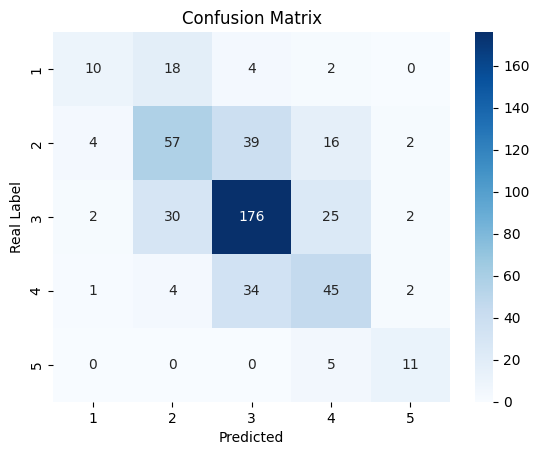

In [17]:
# Define the range of labels explicitly (1 to 5)
label_range = [1, 2, 3, 4, 5]

# Generate the confusion matrix
conf_matrix = confusion_matrix(
    df3['tone'].astype(int), 
    df3['predicted_label'].astype(int), 
    labels=label_range
)

# Plot the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_range, yticklabels=label_range)
plt.xlabel('Predicted')
plt.ylabel('Real Label')
plt.title('Confusion Matrix')
plt.show()

### Rewrite impolite sentences with OpenAi (GPT 4o):

In [18]:
Sample1 = test_dataframe[test_dataframe['tone'] == 1].iloc[10]['review']
pprint('Sample1: '+Sample1)

# ChatGPT client:
client = OpenAI(
    api_key=OPENAI_APIKEY,
    project=OPENAI_PROJECT
)

PromptClassify = [
        {"role": "system", "content":   "You are a helpful technical assistant,\
                                        specialist in non violent communication, politeness and all communication matters.\
                                        You are rating texts on a scale of 1 to 5 for politeness, from Highly Impolite (1) to Highly Polite (5)."}, 
        {"role": "user", "content":     "I need help with a Peer Review comment.\
                                        in a scale of 1 - 5 classify the comment about it's Politeness.\
                                        How to classify (in a range):\
                                        Highly Impolite (1): Comments containing unnecessarily offensive, sarcastic,\
                                        or disrespectful critiques, using derogatory terms or expressing disdain for the reviewed work.\
                                        Highly Polite (5): Comments explicitly emphasizing positive aspects, using linguistic mitigations,\
                                        direct praise, and respectful language to convey critiques or suggestions.\
                                        Neutral (3) would be a comment that is neither polite nor impolite.\
                                        Bring the rank first, then after a 2 line explanation why, of this comment:"+Sample1},
    ]

PromptRewrite = [
        {"role": "system", "content":   "You are a helpful technical assistant,\
                                        specialist in non violent communication, politeness and all communication matters.\
                                        You are rewriting impolite comments to be more polite."}, 
        {"role": "user", "content":     "I need help with a comment, Don't lose any content of the comment just rewrite it more politely. \
                                        Don't write anything else in the reply, just the rewritten comment.\
                                        Rewrite more politely: "+Sample1},
    ]


completion = client.chat.completions.create(
    model="gpt-4o",
    # messages = PromptClassify
    messages = PromptRewrite
)

response = completion.choices[0].message.content
pprint(response)

('Sample1: although finding novel gan applications is an exciting topic i am '
 'not really convinced that ica with the proposed wasserstein gan based '
 'technique fulfills this goal')
('While exploring novel GAN applications is indeed an exciting topic, I am not '
 'entirely convinced that the proposed ICA with the Wasserstein GAN-based '
 'technique fully achieves this objective.')


In [19]:
# Classification of the rewritten comment:

RewritePrediction = pipe(response, top_k=None)
RewritePrediction

[{'label': 'LABEL_1', 'score': 0.4499819576740265},
 {'label': 'LABEL_3', 'score': 0.23685279488563538},
 {'label': 'LABEL_2', 'score': 0.2277558296918869},
 {'label': 'LABEL_0', 'score': 0.06684447824954987},
 {'label': 'LABEL_4', 'score': 0.01856493391096592}]

### Rewritten Predictions pipeline:

In [26]:
## Predictions pipeline:

def RewritePolite(Sample: str):
    PromptRewrite = [
        {"role": "system", "content":   "You are a helpful technical assistant,\
                                        specialist in non violent communication, politeness and all communication matters.\
                                        You are rewriting impolite comments to be more polite."}, 
        {"role": "user", "content":     "I need help with a comment, Don't lose any content of the comment just rewrite it more politely. \
                                        Don't write anything else in the reply, just the rewritten comment.\
                                        Rewrite more politely: "+Sample},]
    
    completion = client.chat.completions.create(
        model="gpt-4o",
        messages = PromptRewrite)
    
    response = completion.choices[0].message.content
    return response

def PredictTone(review: str):
    prediction = pipe(review, top_k=None)
    return prediction


complete_test_dataframe = df3.copy()
complete_test_dataframe['rewritten_review'] = complete_test_dataframe['review'].apply(RewritePolite) ## ~10 min rodando
complete_test_dataframe

## > 10 min

,review,tone,predicted_label,score,rewritten_review
2368,all the comments have been successfully addressed,3,4,0.77732,All the comments have been thoughtfully addres...
642,the writing is often arrestingly pedestrian,2,4,0.35930,The writing tends to be straightforward and un...
2259,the paper seems wellwritten and technically so...,3,4,0.77032,The paper appears to be well-written and techn...
1643,surely if we reduce overfitting then by defini...,4,3,0.93592,"Certainly, if we reduce overfitting, it should..."
2409,the authors have satisfactorily adressed to re...,4,4,0.78587,The authors have addressed the reviewers' conc...
...,...,...,...,...,...
1063,i do not understand why we would like to assume,2,2,0.83550,I am curious about the reasoning behind our de...
1686,it seems you have exchanged first name and las...,2,2,0.79779,It appears that the first name and last name m...
237,it is unclear how this would advance the field...,2,3,0.95192,It is not immediately clear how this would adv...
441,pity about the main thesis,3,2,0.66619,It’s unfortunate about the main thesis.


In [27]:
classf_results2 = [] 

for index, row in complete_test_dataframe.iterrows():
    prediction = pipe(row['rewritten_review'], top_k=None)
    ClassificationResult(classf_results2, row['rewritten_review'], index, prediction)

,review,label,score,index
0,All the comments have been thoughtfully addres...,4,0.57928,2368
1,The writing tends to be straightforward and un...,3,0.54450,642
2,The paper appears to be well-written and techn...,4,0.52327,2259
3,"Certainly, if we reduce overfitting, it should...",3,0.76973,1643
4,The authors have addressed the reviewers' conc...,4,0.79830,2409
...,...,...,...,...
484,I am curious about the reasoning behind our de...,2,0.72542,1063
485,It appears that the first name and last name m...,3,0.81983,1686
486,It is not immediately clear how this would adv...,3,0.89136,237
487,It’s unfortunate about the main thesis.,2,0.69920,441


In [28]:
predicted_dataframe2 = pd.DataFrame(classf_results2)
predicted_dataframe2.set_index('index', inplace=True)
predicted_dataframe2.rename(columns={'label':'rewrite_predicted_label','score':'rewrite_score'}, inplace=True)
df4 = pd.concat([complete_test_dataframe, predicted_dataframe2[['rewrite_predicted_label','rewrite_score']]], axis=1)
df4

,review,tone,predicted_label,score,rewritten_review,rewrite_predicted_label,rewrite_score
2368,all the comments have been successfully addressed,3,4,0.77732,All the comments have been thoughtfully addres...,4,0.57928
642,the writing is often arrestingly pedestrian,2,4,0.35930,The writing tends to be straightforward and un...,3,0.54450
2259,the paper seems wellwritten and technically so...,3,4,0.77032,The paper appears to be well-written and techn...,4,0.52327
1643,surely if we reduce overfitting then by defini...,4,3,0.93592,"Certainly, if we reduce overfitting, it should...",3,0.76973
2409,the authors have satisfactorily adressed to re...,4,4,0.78587,The authors have addressed the reviewers' conc...,4,0.79830
...,...,...,...,...,...,...,...
1063,i do not understand why we would like to assume,2,2,0.83550,I am curious about the reasoning behind our de...,2,0.72542
1686,it seems you have exchanged first name and las...,2,2,0.79779,It appears that the first name and last name m...,3,0.81983
237,it is unclear how this would advance the field...,2,3,0.95192,It is not immediately clear how this would adv...,3,0.89136
441,pity about the main thesis,3,2,0.66619,It’s unfortunate about the main thesis.,2,0.69920


In [39]:
pprint(df4['predicted_label'].value_counts().sort_index())
pprint(df4['rewrite_predicted_label'].value_counts().sort_index())

predicted_label
1     17
2    109
3    253
4     93
5     17
Name: count, dtype: int64
rewrite_predicted_label
1      2
2     73
3    210
4    156
5     48
Name: count, dtype: int64


### GPT Classification:

In [63]:
## Classify with GPT-4o:

def GptClassification(Sample: str):
    PromptClassify1 = [
            {"role": "system", "content":   "You are a helpful technical assistant,\
                                            specialist in non violent communication, politeness and all communication matters.\
                                            You are rating texts on a scale of 1 to 5 for politeness, from Highly Impolite (1) to Highly Polite (5)."}, 
            {"role": "user", "content":     "I need help with a Peer Review comment.\
                                            in a scale of 1 - 5 classify the comment about it's Politeness.\
                                            How to classify (in a range):\
                                            Highly Impolite (1): Comments containing unnecessarily offensive, sarcastic,\
                                            or disrespectful critiques, using derogatory terms or expressing disdain for the reviewed work.\
                                            Highly Polite (5): Comments explicitly emphasizing positive aspects, using linguistic mitigations,\
                                            direct praise, and respectful language to convey critiques or suggestions.\
                                            Neutral (3) would be a comment that is neither polite nor impolite.\
                                            In a json format: {'label':'_ClassificationResult_', 'explanation':'_Explanation_'} \
                                            Bring up the politeness rating of the comment at the _ClassificationResult_, then after a 2 line explanation why at the _Explanation_, \
                                            of this comment:"+Sample},
        ]
    
    PromptClassify2 = [
            {"role": "system", "content":   "You are a helpful technical assistant,\
                                            specialist in non violent communication, politeness and all communication matters.\
                                            You are rating texts on a scale of 1 to 5 for politeness, from Highly Impolite (1) to Highly Polite (5)."}, 
            {"role": "user", "content":     "In a scale of 1 - 5 classify the comment about it's Politeness.\
                                            In a json format: {'label':'_ClassificationResult_', 'explanation':'_Explanation_'} \
                                            Bring up the politeness rating of the comment at the _ClassificationResult_, then after a 2 line explanation why at the _Explanation_, \
                                            of this comment:"+Sample},
        ]
        
    completion1 = client.chat.completions.create(
        model="gpt-4o",
        messages = PromptClassify1,
        temperature = 0.1
        )
    
    completion2 = client.chat.completions.create(
        model="gpt-4o",
        messages = PromptClassify2,
        temperature = 0.1
        )

    return completion1.choices[0].message.content, completion2.choices[0].message.content

def SimpleFormatting(text):
    '''function that returns a json from a string in json format'''    
    json_string = text.strip('```json').strip()
    return json.loads(json_string)

## Examples:
# comment = "although finding novel gan applications is an exciting topic i am \
#     not really convinced that ica with the proposed wasserstein gan based \
#     technique fulfills this goal"
# comment = "the writing is often arrestingly pedestrian"

# rewritten_comment = "while exploring novel gan applications is indeed an exciting topic i am not \
#     entirely convinced that the proposed ica with the wasserstein gan based \
#     technique fully achieves this objective."
# rewritten_comment = "The writing tends to be straightforward and uncomplicated."
    
# rank1, rank2 = GptClassification(comment)
# pprint(rank1)
# print('\n')
# pprint(rank2)

df5 = df4.copy()

for index, row in df5.iterrows():
    rank1, rank2 = GptClassification(row['review'])
    try:
        rank1 = SimpleFormatting(rank1)
        df5.at[index, 'GptClassification:'] = rank1['label']
    except Exception as e:
        print('Exception at json dump (moving forward):', e)

## > 34 min

In [64]:
df5

,review,tone,predicted_label,score,rewritten_review,rewrite_predicted_label,rewrite_score,GptClassification:
2368,all the comments have been successfully addressed,3,4,0.77732,All the comments have been thoughtfully addres...,4,0.57928,5
642,the writing is often arrestingly pedestrian,2,4,0.35930,The writing tends to be straightforward and un...,3,0.54450,2
2259,the paper seems wellwritten and technically so...,3,4,0.77032,The paper appears to be well-written and techn...,4,0.52327,4
1643,surely if we reduce overfitting then by defini...,4,3,0.93592,"Certainly, if we reduce overfitting, it should...",3,0.76973,3
2409,the authors have satisfactorily adressed to re...,4,4,0.78587,The authors have addressed the reviewers' conc...,4,0.79830,5
...,...,...,...,...,...,...,...,...
1063,i do not understand why we would like to assume,2,2,0.83550,I am curious about the reasoning behind our de...,2,0.72542,3
1686,it seems you have exchanged first name and las...,2,2,0.79779,It appears that the first name and last name m...,3,0.81983,2
237,it is unclear how this would advance the field...,2,3,0.95192,It is not immediately clear how this would adv...,3,0.89136,3
441,pity about the main thesis,3,2,0.66619,It’s unfortunate about the main thesis.,2,0.69920,2


In [66]:
## Save df5 to a csv file
df5.to_csv('complete_dataframe.csv', index=True)

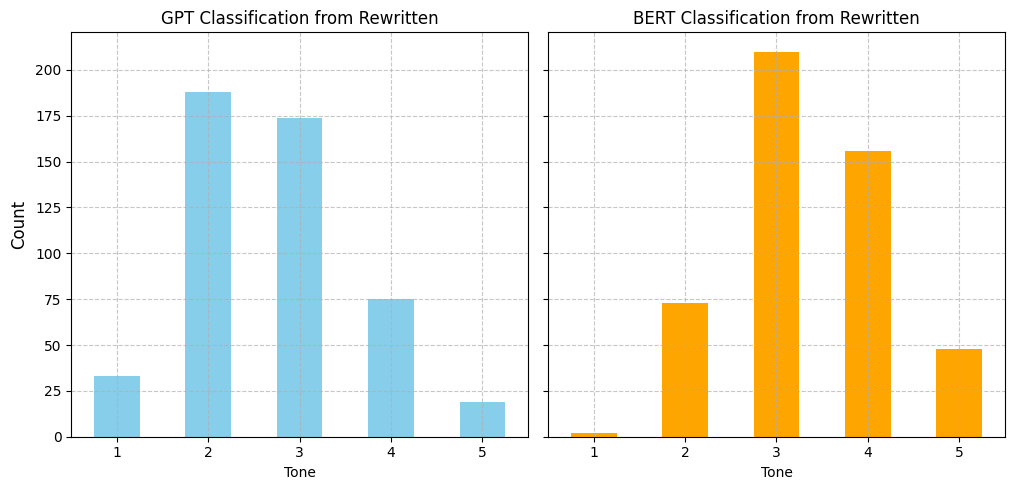

In [160]:
# Histogram of predicted labels:
# df5['GptClassification:'].value_counts().sort_index().plot(kind='bar')
# plt.title('GPT Classification from Rewritten')
# plt.xticks(ticks=[0, 1, 2, 3, 4], rotation=0)
# plt.xlabel('Tone')
# plt.grid(ls='--', alpha=0.7)
# plt.show()

# df5['rewrite_predicted_label'].value_counts().sort_index().plot(kind='bar')
# plt.title('BERT Classification from Rewritten')
# plt.xticks(ticks=[0, 1, 2, 3, 4], rotation=0)
# plt.xlabel('Tone')
# plt.grid(ls='--', alpha=0.7)
# plt.show()

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

# Plot for GPT Classification
df5['GptClassification:'].value_counts().sort_index().plot(kind='bar', ax=axes[0], color='skyblue')
axes[0].set_title('GPT Classification from Rewritten')
axes[0].set_xticks([0, 1, 2, 3, 4])
axes[0].set_xticklabels([1, 2, 3, 4, 5], rotation=0)  # Assuming tone labels are 1-5
axes[0].set_xlabel('Tone')
axes[0].grid(ls='--', alpha=0.7)

# Plot for BERT Classification
df5['rewrite_predicted_label'].value_counts().sort_index().plot(kind='bar', ax=axes[1], color='orange')
axes[1].set_title('BERT Classification from Rewritten')
axes[1].set_xticks([0, 1, 2, 3, 4])
axes[1].set_xticklabels([1, 2, 3, 4, 5], rotation=0)  # Assuming tone labels are 1-5
axes[1].set_xlabel('Tone')
axes[1].grid(ls='--', alpha=0.7)

# Set shared y-axis label
fig.text(-0.01, 0.5, 'Count', rotation=90, fontsize=12)

# Adjust layout and show the plot

plt.tight_layout()
plt.show()

### Evaluation:

In [113]:
## Hand Made Calculations (not necessary):
'''
    ## Precision for every class:

    # Functions to compute True Positives, True Negatives, False Positives and False Negatives
    def true_positive(y_true, y_pred):   
        tp = 0
        for yt, yp in zip(y_true, y_pred):
            if yt == 1 and yp == 1:
                tp += 1
        return tp

    def true_negative(y_true, y_pred):
        tn = 0
        for yt, yp in zip(y_true, y_pred):
            if yt == 0 and yp == 0:
                tn += 1
        return tn

    def false_positive(y_true, y_pred):
        fp = 0
        for yt, yp in zip(y_true, y_pred):
            if yt == 0 and yp == 1:
                fp += 1
        return fp

    def false_negative(y_true, y_pred):
        fn = 0
        for yt, yp in zip(y_true, y_pred):
            if yt == 1 and yp == 0:
                fn += 1
        return fn

    #Computation of macro-averaged precision
    def macro_precision(y_true, y_pred):
        
        # find the number of classes
        num_classes = len(np.unique(y_true))

        # initialize precision to 0
        precision = 0
        
        # loop over all classes
        for class_ in list(y_true.unique()):
            
            # all classes except current are considered negative
            temp_true = [1 if p == class_ else 0 for p in y_true]
            temp_pred = [1 if p == class_ else 0 for p in y_pred]
            
            
            # compute true positive for current class
            tp = true_positive(temp_true, temp_pred)
            
            # compute false positive for current class
            fp = false_positive(temp_true, temp_pred)
            
            # compute precision for current class
            temp_precision = tp / (tp + fp + 1e-6)
            # keep adding precision for all classes
            precision += temp_precision
            
            print('Precision:', temp_precision, '\t| Class:', class_)
            
        # calculate and return average precision over all classes
        precision /= num_classes
        
        return precision

    ## True labels
    y_true = df5['tone'].astype(int)     

    ## BERT predictions
    y_pred = df5['predicted_label'].astype(int)

    precision = macro_precision(y_true, y_pred)
    precision
'''

Precision: 0.6956521711634301 	| Class: 3
Precision: 0.5229357750189378 	| Class: 2
Precision: 0.4838709625390219 	| Class: 4
Precision: 0.588235259515573 	| Class: 1
Precision: 0.6470587854671302 	| Class: 5


0.5875505907408186

In [120]:
## Precision and Recall:

## True labels
y_true = df5['tone'].astype(int)     

## BERT predictions
y_pred = df5['predicted_label'].astype(int)

# Average precision and recall:
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')

# Compute precision and recall for each class
precision_per_class = precision_score(y_true, y_pred, average=None)
recall_per_class = recall_score(y_true, y_pred, average=None)

# Display average precision and recall
print('Avg Precision:', round(precision, 3), '\t| Avg Recall:', round(recall, 3), '\n')

# Display precision and recall for each class
for cls, (prec, rec) in enumerate(zip(precision_per_class, recall_per_class), start=1):
    print(f'Class {cls} - Precision: {round(prec, 3)}, Recall: {round(rec, 3)}')

Avg Precision: 0.588 	| Avg Recall: 0.547 

Class 1 - Precision: 0.588, Recall: 0.294
Class 2 - Precision: 0.523, Recall: 0.483
Class 3 - Precision: 0.696, Recall: 0.749
Class 4 - Precision: 0.484, Recall: 0.523
Class 5 - Precision: 0.647, Recall: 0.688


In [108]:
## True labels
y_true = df5['tone'].astype(int)     

## BERT predictions
y_pred = df5['predicted_label'].astype(int)

# precision = macro_precision(y_true, y_pred)
# precision

num_classes = len(np.unique(y_true))
precision = 0
for class_ in list(y_true.unique()):
        
    # all classes except current are considered negative
    temp_true = [1 if p == class_ else 0 for p in y_true]
    temp_pred = [1 if p == class_ else 0 for p in y_pred]
    
    # print('Temp True:', temp_true)
    # print('Temp Pred:', temp_pred)
    
    # compute true positive for current class
    tp = true_positive(temp_true, temp_pred)
    
    # compute false positive for current class
    fp = false_positive(temp_true, temp_pred)
    
    # print('TP:', tp)
    # print('FP:', fp)
    
    # compute precision for current class
    temp_precision = tp / (tp + fp + 1e-6)
    
    # keep adding precision for all classes
    precision += temp_precision
        
    # calculate and return average precision over all classes
    precision /= num_classes
    
    print('Precision:', precision, '| Class:', class_)
    
precision

Precision: 0.13913043423268603 | Class: 3
Precision: 0.13241324185032477 | Class: 2
Precision: 0.12325684087786933 | Class: 4
Precision: 0.14229842007868848 | Class: 1
Precision: 0.15787144110916373 | Class: 5


0.15787144110916373

In [102]:
df5[df5['predicted_label'] == '1']

,review,tone,predicted_label,score,rewritten_review,rewrite_predicted_label,rewrite_score,GptClassification:
191,the ms comes over very much like a group of ol...,1,1,0.69219,The manuscript gives the impression of a gathe...,4,0.33298,2
56,the work that this group does is a disgrace to...,1,1,0.76426,The work of this group does not align with wha...,3,0.39930,1
1181,are there plans to release the authors ill lik...,1,1,0.46215,Are there plans to release information about t...,2,0.64302,1
285,claiming insights that rarely amount to very m...,1,1,0.70710,While the insights may sometimes seem quite ev...,3,0.45438,1
1126,hence the novelty of this paper is limited to ...,1,1,0.71916,"Hence, the novelty of this paper appears to be...",3,0.64850,1
2167,in retrospect i wish the authors would have sp...,2,1,0.74812,"Upon reflection, I would have appreciated if t...",4,0.40059,3
176,the writer of the manuscript is utterly ridicu...,1,1,0.73401,The writer of the manuscript seems to have an ...,4,0.44359,1
100,this is a perfect example of the worst kind of...,2,1,0.49966,This research in social psychology appears to ...,3,0.53634,1
251,to put it bluntly the last thing i want is a r...,2,1,0.60090,"To be honest, I would prefer that my papers ar...",2,0.65165,2
531,the authors should take the time to thoroughly...,3,1,0.70366,It would be greatly appreciated if the authors...,4,0.77433,2


---
**Observações (conclusões parciais):**
- Dataset está com uns comentarios negativos que poderiam ser classificados como Neutro+, pode estar trazendo problemas de viés.
- Presença de ironia em muitos comentários, o que pode confundir a identificação de politeness ("the writing is often arrestingly pedestrian"), GPT a princípio lidou bem com alguns desses casos que eu analisei manualmente (ainda tenho que avaliar mais um ou dois para isso). 
- Questão de desbalanceamento de classes pode ter trazido uma questão de viés forte também (classe 3 como muito predominante).

<br>

**Conversa com a Karin:** 
- Intro: qual é a proposta do trabalho - verificação do chat gpt como reescrita de comentarios para mais polite, e classificação de politeness. Análise de erros do modelo.
    - Avaliar a performance dos meus `3` modelos classificadores
    - Avaliação da Reescrita, quais são os casos que ele não escreve bem.
    - Anotar manualmente essa reescrita, comparar com a classificação.
- Conclusões: 
    - Comparações entre anotação manual e resultados dos classificadores.

**Lista de tarefas compilada (Em ordem):**
- [<font color='greenyellow'> **Done** </font>] Tem que rodar para todos os casos, colocar os resultados disso e também os comentarios reescritos em 2 colunas no dataframe de teste 
- [<font color='greenyellow'> **Done** </font>] Depois rodar a classificação com o GPT mesmo, e colocar o resultado numa outra coluna no mesmo dataset. 
- Formalizar métricas de avaliação, terminar essa parte para depois que treinar outros modelos só replicas as métricas. (Avaliar com métricas de classificação multi-classe)
- Alterar a reescrita polite para apenas reescrever o que é 1 e 2, objetivo é tentar tranformar isso em 4 ou 5.
    - Ver sobre fazer anotação manual destes novos reescritos (pessoal da poatek)
- Treinar um modelo BERT só com 3 classes, dai fazer TUDO igual msm coisa mas com esse modelo (adaptar os resultados para 1, 2, 3 tendo 1, 2, 3, 4, 5) \
- Juntar Labels [1 e 2], [4 e 5], Escrever métricas de avaliação para o classificador BERT e GPT baseadas nessa junção, ver se teve melhora.
- Re-Treinar o BERT só com 3 labels.
- Treinar o modelo de classificação clássico (NB ou RF) com 5 labels e com 3 labels.
- Avaliar com todas as métricas de performance já estabelecidas anteriormente.
- Transformar o que é 3 em Polite. (finalidade: ver se a reescrita realmente foi eficaz ou não, caso muitos foram para 4 ou 5, ou no caso Polite)
    - Ver sobre fazer anotação/avaliação manual destes novos reescritos (pessoal da poatek)
- Avaliar quais são os casos de erro. 
    - Quais são os maiores motivos de erro: ironia/qual label ele mais erra/as frases têm algo em comum... ?


In [ ]:
## depois da classificação com o GPT, fazer tudo com 3 classes apenas.